In [1]:
%matplotlib inline

## Load the necessary Python libraries required for this project. 

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import requests

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Getting Started

In this project, you will evaluate the performance and predictive power of a model that has been trained and tested on data collected from houses. A model trained on this data that is seen as a good fit could then be used to make certain predictions about a home — in particular, its number of bedrooms. This model can provide valuable insights to business in a real estate who could make use of such information on a daily basis.

Run the code cell below to load the dataset.

In [3]:
url="https://storage.googleapis.com/street_group_data_science/street_group_data_science_bedrooms_test.json "

In [4]:
df = pd.read_json(url,lines=True)

# Check for missing data

In [5]:
print("number of NaN values for the data :", df.isnull().sum())

number of NaN values for the data : property_type             0
total_floor_area          0
number_habitable_rooms    0
number_heated_rooms       0
estimated_min_price       0
estimated_max_price       0
latitude                  0
longitude                 0
bedrooms                  0
dtype: int64


# Check for duplicates

In [6]:
# Remove all duplictes
df1=df.drop_duplicates()
duplicates=df.shape[0]-df1.shape[0]
print('There were' + ' %s'%duplicates + ' duplicates')

There were 386 duplicates


# Split the data into test set  and train set

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into features and the target variable. The features, 'total_floor_area',  'latitude', 'longitude',  'estimated_min_price' and'estimated_max_price', give us quantitative information about each data point. The target variable, 'bedrooms', will be the variable we seek to predict. 

In [7]:
df_X=df.copy()
# First replacing variables with four or less categories
df_X['new_property_type'] = df_X['property_type'].replace(['Detached','Flats/Maisonettes','Semi-Detached','Terraced'],[1,2,3,4]) 

In [8]:
''' Split data on train and test'''

# define response variable
df_y=df_X['bedrooms']

# drop categorical and target variable
df_X.drop('bedrooms',axis=1,inplace=True)
df_X.drop('property_type',axis=1,inplace=True)

# set global random state
random_state = 11

# split data
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=random_state)


In [9]:
# find the shape of the data
print(df.shape)

(1000000, 9)


In [10]:
# find the shapr of train-test-split
print('X_test',X_test.shape)
print('y_test',y_test.shape)
print('X_train',X_train.shape)
print('y_train',y_train.shape)

X_test (200000, 8)
y_test (200000,)
X_train (800000, 8)
y_train (800000,)


First I will use three models namely: Naive Bayes, K-Nearest Neighbor and decision tree
without any hyperparameter tuning to determine how they predict the target.

In [11]:
# Plot ROC curve
def plot_roc(y_pred,title):
    '''This function plots the ROC-AUC curve'''
    title=title
    y_prob_pred_cnb=y_pred
    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 7

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob_pred_cnb[:,i], pos_label=i)

    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='bedroom 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='bedroom 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='bedroom 2 vs Rest')
    plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='bedroom 3 vs Rest')
    plt.plot(fpr[4], tpr[4], linestyle='--',color='magenta', label='bedroom 4 vs Rest')
    plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='bedroom 5 vs Rest')
    plt.plot(fpr[6], tpr[6], linestyle='--',color='black', label='bedroom 6 vs Rest')

    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300);   
    plt.show()

In [12]:
def model(X_train,y_train,X_test,y_test):
    
        ''' THis function appliy three different models for the classification of 
        the target variable.The three models are Naive Bayes, Decision Tree and K-nn. 
        A random search hyper-parameter tuning algorithm is used to fine tune 
        the hyper-parameters.The output of the function is the accuracy and ROC.'''
    
        model_dict = { 0:'NaiveBayes', 1:'Knn', 2:'DesionTree'}

        # NB
        
        # Define the hyperparameter configuration space
        gnb=GaussianNB()
        nb_params = {'var_smoothing': np.logspace(0,-30, num=100)}
        gs_nb = RandomizedSearchCV(gnb, nb_params, cv=3, scoring='accuracy')
        gs_nb.fit(X_train, y_train)
        y_pred_cnb = gs_nb.predict(X_test)
        y_prob_pred_cnb = gs_nb.predict_proba(X_test)
        score_nb= metrics.accuracy_score(y_test,y_pred_cnb)


        #roc auc score
        auc_nb =roc_auc_score(y_test, y_prob_pred_cnb, multi_class='ovo', average='weighted')
        plot_roc(y_prob_pred_cnb,'Naive Bayes ROC')
        print('Confusion Matrix Naive Bayes')
        print(metrics.confusion_matrix(y_test,y_pred_cnb))
        print(metrics.classification_report(y_test,y_pred_cnb,digits=3))
        print('Estimator: ',model_dict[0])
        print("Auc:",auc_nb)
        print('=================================================')
        
        
        #KNN
        
        # Define the hyperparameter configuration space
        knn_params = {
            'n_neighbors': [2, 3, 5,10,15,20],
        }
        clf = KNeighborsClassifier()
        gs_knn = clf.fit(X_train, y_train)
        y_pred_knn=gs_knn.predict(X_test)
        y_prob_pred_knn=gs_knn.predict_proba(X_test)
        auc_knn = roc_auc_score(y_test, y_prob_pred_knn, multi_class='ovo', average='weighted')
        plot_roc(y_prob_pred_knn,'K-Nearest Neighbor Bayes ROC')
        score_knn= metrics.accuracy_score(y_test,y_pred_knn)
        
        print('Confusion Matrix K-NN')
        print(metrics.confusion_matrix(y_test,y_pred_knn))
        print(metrics.classification_report(y_test,y_pred_knn,digits=3))
        print('Estimator: ',model_dict[1])
        print("Auc:",auc_knn)
        print('=================================================')
        
        # DT
        
        # Define the hyperparameter configuration space
        dt_params = {
            'max_leaf_nodes': [10, 20, 30],
            'max_features': ['sqrt',0.5],
            'max_depth': [15,20,30,50],
            'min_samples_leaf': [1,2,4,8],
            #"bootstrap":[True,False],
            "criterion":['gini','entropy']
        }
        clf = DecisionTreeClassifier(random_state=0)
        gs_dt = clf.fit(X_train, y_train)
        y_pred_dt=gs_dt.predict(X_test)
        y_prob_pred_dt=gs_dt.predict_proba(X_test)
        auc_dt = roc_auc_score(y_test, y_prob_pred_dt, multi_class='ovo', average='weighted')
        plot_roc(y_prob_pred_dt,'Decision Tree Bayes ROC')
        score_dt = metrics.accuracy_score(y_test,y_pred_dt)
        
        print('Confusion Matrix K-NN')
        print(metrics.confusion_matrix(y_test,y_pred_dt))
        print(metrics.classification_report(y_test,y_pred_dt,digits=3))
        print('Estimator: ',model_dict[2])
        print("Auc:",auc_dt)
        print('=================================================')
        
        # make dictionaries for plotting
        auc_dict={0:auc_nb,1:auc_knn,2:auc_dt,}
        result_dict={0:score_nb,1:score_knn,2:score_dt}
        
        
        # plot the performance
        plt.plot(model_dict.values(), auc_dict.values(), c='r')
        plt.plot(model_dict.values(), result_dict.values(), c='b')
        plt.xlabel('Models')
        plt.xticks(rotation=45)
        plt.ylabel('Accouracy and ROC_AUC')
        plt.title('Result of Randomized Search')
        plt.legend(['Accuracy', 'ROC_AUC'])
        plt.show();
        
        
        
        # Model performance during Grid Search
        performance= pd.DataFrame(list(zip(model_dict.values(), result_dict.values(), auc_dict.values())), \
                              columns=['Model', 'Accuracy_rate','Roc_auc_rate'])
        print(performance)

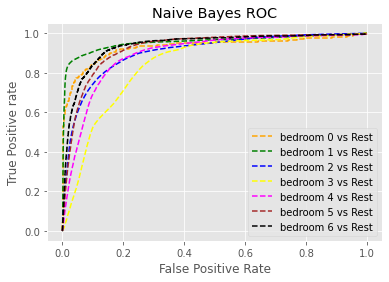

Confusion Matrix Naive Bayes
[[    6   413    68    22    12     6     0     0     0     1]
 [   25  8888  1925   329   111    35     9     3     0     5]
 [   11  1289 47613  6738   660   105    24     5     1    15]
 [    3   286 22773 59463  6445   452   111    24     9     7]
 [    1    53   514 11740 17397  2223   205    60     4    10]
 [    0     7    55   741  3682  2580   453   113     7     7]
 [    0     5    14    91   510   701   261   128    13    16]
 [    0     0     3     8    63   103    89    70    14    10]
 [    0     0     0     3    21    40    14    29     9     6]
 [    0     0     2     3     4     4     4     8     7     3]]
              precision    recall  f1-score   support

           0      0.130     0.011     0.021       528
           1      0.812     0.784     0.798     11330
           2      0.653     0.843     0.736     56461
           3      0.751     0.664     0.705     89573
           4      0.602     0.540     0.569     32207
           5   

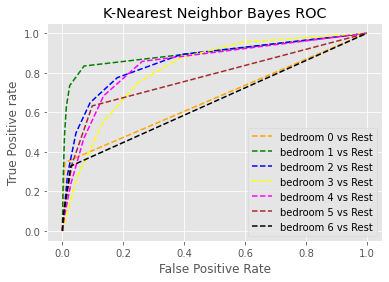

Confusion Matrix K-NN
[[   35   350   101    29    10     3     0     0     0     0]
 [   79  7433  3162   535    97    20     3     1     0     0]
 [   19  2267 37847 15563   698    58     8     1     0     0]
 [    9   359 11254 69848  7699   374    27     3     0     0]
 [    2    89   871 12921 16729  1522    64     8     1     0]
 [    0    30   142  1693  4327  1340   103    10     0     0]
 [    0    10    43   353   829   441    56     7     0     0]
 [    0     3    10    64   136   128    14     5     0     0]
 [    0     1     3    30    51    29     8     0     0     0]
 [    0     0     3    10    10     9     3     0     0     0]]
              precision    recall  f1-score   support

           0      0.243     0.066     0.104       528
           1      0.705     0.656     0.680     11330
           2      0.708     0.670     0.689     56461
           3      0.691     0.780     0.733     89573
           4      0.547     0.519     0.533     32207
           5      0.34

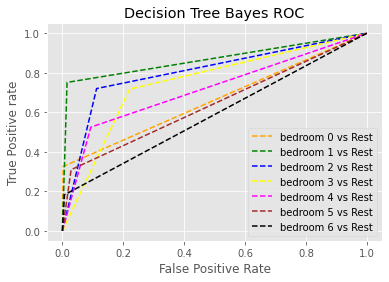

Confusion Matrix K-NN
[[  172   229    77    32    12     2     4     0     0     0]
 [  261  8513  1902   480   127    28    13     3     3     0]
 [  137  1963 40659 12446  1065   163    18     6     2     2]
 [   35   487 12898 64245 10582  1124   154    29    17     2]
 [    9   134  1022 10104 16905  3461   465    79    20     8]
 [    2    46   167  1109  3243  2368   576   106    22     6]
 [    0    16    38   161   507   582   318    86    23     8]
 [    0     1     9    27    66   101    83    48    20     5]
 [    1     1     4     5    22    39    25    14     7     4]
 [    0     1     3     4     6     6     8     4     2     1]]
              precision    recall  f1-score   support

           0      0.279     0.326     0.300       528
           1      0.747     0.751     0.749     11330
           2      0.716     0.720     0.718     56461
           3      0.725     0.717     0.721     89573
           4      0.520     0.525     0.522     32207
           5      0.30

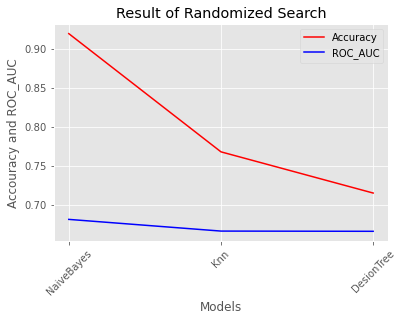

        Model  Accuracy_rate  Roc_auc_rate
0  NaiveBayes       0.681450      0.919493
1         Knn       0.666465      0.767999
2  DesionTree       0.666180      0.715202
Wall time: 41 s


In [13]:
%%time
model(X_train,y_train,X_test,y_test)

### Best model

Here I have used ROC_AUC metrics for evaluating different models with additional
monitoring of the accuracy metric dynamic.This approach will allow us to explore models from different angles.

Our best performed model with ROC_AUC (0.919493) metric is Naive Bayes . 
This classifier could achive accuracy rate 0.681450.  The average accuracy 
among all classifiers is 0.6713649.

# Tuning the Hyperparameter

Next I would tune the hyperparameter to check if the model's performance can be improved.

In [14]:
def model(X_train,y_train,X_test,y_test):
    
        ''' THis function applied three different models for the classification of the target variable.
        The three models are Random Forest Classifier, Decision Tree and K-nn. A grid search hyper-parameter
        tuning algorithm is used to fine tune the hyper-parameters. In machine learning, hyperparameter 
        optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning 
        algorithm. A hyperparameter is a parameter whose value is used to control the learning process.
        
        The output of the function is the accuracy and ROC.'''
    
        model_dict = { 0:'NaiveBayes', 1:'Knn', 2:'DesionTree'}

        #Random Forest
        
        # Define the hyperparameter configuration space
        gnb=GaussianNB()
        nb_params = {'var_smoothing': np.logspace(0,-20, num=100)}
        gs_nb = RandomizedSearchCV(gnb, nb_params, cv=3, scoring='accuracy')
        gs_nb.fit(X_train, y_train)
        y_pred_cnb = gs_nb.predict(X_test)
        y_prob_pred_cnb = gs_nb.predict_proba(X_test)


        #roc auc score
        auc_nb =roc_auc_score(y_test, y_prob_pred_cnb, multi_class='ovo', average='weighted')
        plot_roc(y_prob_pred_cnb,'Naive Bayes ROC')
        print('Confusion Matrix Naive Bayes')
        print(metrics.confusion_matrix(y_test,y_pred_cnb))
        print(metrics.classification_report(y_test,y_pred_cnb,digits=3))
        print('Estimator: ',model_dict[0])
        print('Best parameters:',gs_nb.best_params_)
        print("Auc:",auc_nb)
        print('=================================================')
        
    

        #KNN
        
        # Define the hyperparameter configuration space
        knn_params = {
            'n_neighbors': range(5,15),
        }
        clf = KNeighborsClassifier()
        gs_knn = RandomizedSearchCV(clf, knn_params, cv=3, scoring='accuracy')
        gs_knn.fit(X_train, y_train)
        y_pred_knn=gs_knn.predict(X_test)
        y_prob_pred_knn=gs_knn.predict_proba(X_test)
        auc_knn = roc_auc_score(y_test, y_prob_pred_knn, multi_class='ovo', average='weighted')
        plot_roc(y_prob_pred_knn,'K-Nearest Neighbor Bayes ROC')
        
        print('Confusion Matrix K-NN')
        print(metrics.confusion_matrix(y_test,y_pred_knn))
        print(metrics.classification_report(y_test,y_pred_knn,digits=3))
        print('Estimator: ',model_dict[1])
        print('Best parameters:',gs_knn.best_params_)
        print("Auc:",auc_knn)
        print('=================================================')
        
        # Decision Tree
        
        # Define the hyperparameter configuration space
        dt_params = {
            'max_leaf_nodes': [10, 20, 30,40],
            'max_features': ['sqrt',0.5],
            'max_depth': [15,20,30,50,60],
            'min_samples_leaf': [1,2,4,8,10],
            #"bootstrap":[True,False],
            "criterion":['gini','entropy']
        }
        clf = DecisionTreeClassifier(random_state=0)
        gs_dt = RandomizedSearchCV(clf, dt_params, cv=3, scoring='accuracy')
        gs_dt.fit(X_train, y_train)
        y_pred_dt=gs_dt.predict(X_test)
        y_prob_pred_dt=gs_dt.predict_proba(X_test)
        auc_dt = roc_auc_score(y_test, y_prob_pred_dt, multi_class='ovo', average='weighted')
        plot_roc(y_prob_pred_dt,'Decision Tree Bayes ROC')
        
        print('Confusion Matrix K-NN')
        print(metrics.confusion_matrix(y_test,y_pred_dt))
        print(metrics.classification_report(y_test,y_pred_dt,digits=3))
        print('Estimator: ',model_dict[2])
        print('Best parameters: ',gs_dt.best_params_)
        print("Auc:",auc_dt)
        print('=================================================')
        
        # make dictionaries for plotting
        auc_dict={0:auc_nb,1:auc_knn,2:auc_dt,}
        result_dict={0:gs_nb.best_score_,1:gs_knn.best_score_,2:gs_dt.best_score_}
        
        
        # plot the performance
        plt.plot(model_dict.values(), auc_dict.values(), c='r')
        plt.plot(model_dict.values(), result_dict.values(), c='b')
        plt.xlabel('Models')
        plt.xticks(rotation=45)
        plt.ylabel('Accouracy and ROC_AUC')
        plt.title('Result of Randomized Search')
        plt.legend(['Accuracy', 'ROC_AUC'])
        plt.show();
        
        
        
        # Model performance during Grid Search
        performance= pd.DataFrame(list(zip(model_dict.values(), result_dict.values(), auc_dict.values())), \
                              columns=['Model', 'Accuracy_rate','Roc_auc_rate'])
        print(performance)

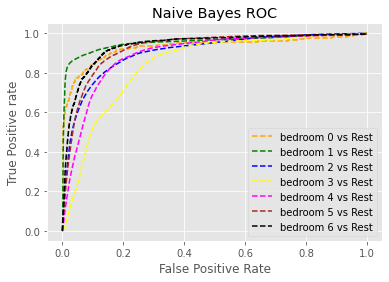

Confusion Matrix Naive Bayes
[[    6   413    68    22    12     6     0     0     0     1]
 [   25  8888  1925   329   111    35     9     3     0     5]
 [   11  1289 47613  6738   660   105    24     5     1    15]
 [    3   286 22773 59463  6445   452   111    24     9     7]
 [    1    53   514 11740 17397  2223   205    60     4    10]
 [    0     7    55   741  3682  2580   453   113     7     7]
 [    0     5    14    91   510   701   261   128    13    16]
 [    0     0     3     8    63   103    89    70    14    10]
 [    0     0     0     3    21    40    14    29     9     6]
 [    0     0     2     3     4     4     4     8     7     3]]
              precision    recall  f1-score   support

           0      0.130     0.011     0.021       528
           1      0.812     0.784     0.798     11330
           2      0.653     0.843     0.736     56461
           3      0.751     0.664     0.705     89573
           4      0.602     0.540     0.569     32207
           5   

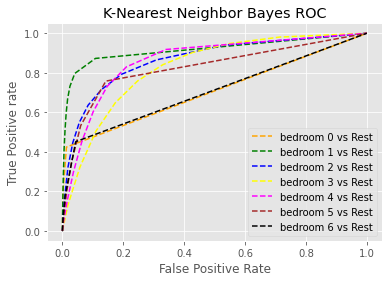

Confusion Matrix K-NN
[[    6   359   115    31    16     1     0     0     0     0]
 [   25  7133  3457   578   111    23     3     0     0     0]
 [    2  2100 37241 16312   734    67     5     0     0     0]
 [    2   276  9937 71338  7677   321    19     3     0     0]
 [    1    60   630 12933 17292  1248    42     1     0     0]
 [    0    22   107  1608  4557  1266    81     4     0     0]
 [    0     5    36   346   882   422    46     2     0     0]
 [    0     0     9    71   153   117     8     2     0     0]
 [    0     1     2    31    51    32     5     0     0     0]
 [    0     0     3     9    12     9     2     0     0     0]]
              precision    recall  f1-score   support

           0      0.167     0.011     0.021       528
           1      0.716     0.630     0.670     11330
           2      0.723     0.660     0.690     56461
           3      0.691     0.796     0.740     89573
           4      0.549     0.537     0.543     32207
           5      0.36

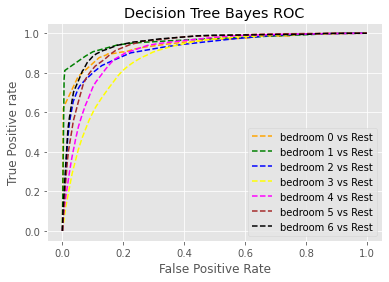

Confusion Matrix K-NN
[[    0   412    69    32    10     5     0     0     0     0]
 [    0  9195  1594   411   107    19     4     0     0     0]
 [    0   798 41417 13769   441    31     5     0     0     0]
 [    0   192  6237 75974  6927   215    28     0     0     0]
 [    0    53   257 10205 19832  1790    70     0     0     0]
 [    0    15    37   728  3983  2672   210     0     0     0]
 [    0     5    10    90   580   837   217     0     0     0]
 [    0     0     1    16    82   134   127     0     0     0]
 [    0     0     0     4    28    48    42     0     0     0]
 [    0     0     1     5     5     5    19     0     0     0]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       528
           1      0.862     0.812     0.836     11330
           2      0.835     0.734     0.781     56461
           3      0.750     0.848     0.796     89573
           4      0.620     0.616     0.618     32207
           5      0.46

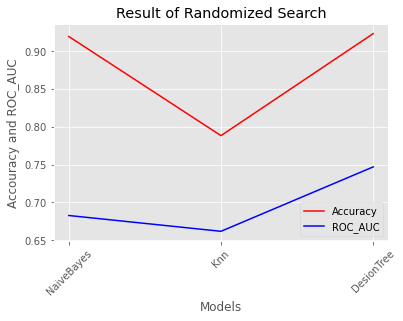

        Model  Accuracy_rate  Roc_auc_rate
0  NaiveBayes       0.682629      0.919493
1         Knn       0.661728      0.788311
2  DesionTree       0.746936      0.923279
Wall time: 7min 9s


In [15]:
%%time
model(X_train,y_train,X_test,y_test)

### Best performing model with tuned hyperparameter

After tuning the hyperparameter we can see that the  performance of Naive Bayes and KNN
do not show significant improvement. However Decision Tree has now become our best performing model
with ROC_AUC (0.923279) and classification accuracy rate of  0.746936.
The average accuracy among all classifiers  is 0.69709666.


## Find the most important features

Although the number of features are already small, nevertheless I would like to find 
which features are most important in terms of model prediction.

Random Forests are often used for feature selection. Random forests naturally
ranks the features by using a tree-based strategies which tell us how well they improve 
the purity of the node.  This mean decrease in impurity over all trees 
(called gini impurity). Nodes with the greatest decrease in impurity
happen at the start of the trees, while notes with the least decrease in impurity 
occur at the end of trees. Thus, by pruning trees below a particular node, we can
create a subset of the most important features

Feature importances are provided by the fitted attribute feature_importances_ and 
they are computed as the mean and standard deviation of accumulation of the impurity 
decrease within each tree.

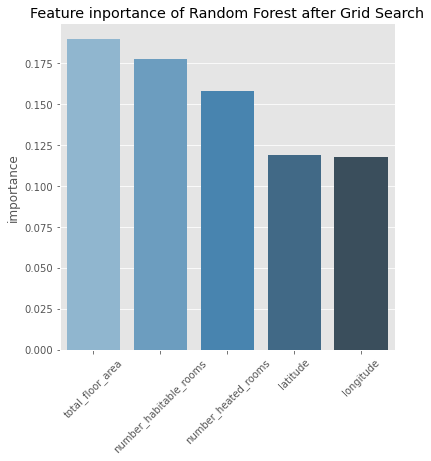

Wall time: 2min 58s


In [16]:
%%time
rf = RandomForestClassifier(random_state=0)
feat_imp= rf.fit(X_train, y_train)
feature_importances = pd.DataFrame(feat_imp.feature_importances_, index =X_train.columns,  
                                   columns=['importance']).sort_values('importance', ascending=False)
fea= pd.DataFrame(feature_importances['importance'].nlargest(5))
plt.figure(figsize=[6,6])
sns.barplot(x=fea.index, y='importance', data=fea, palette="Blues_d")
plt.title('Feature inportance of Random Forest after Grid Search')
plt.xticks(rotation=45)
plt.show();

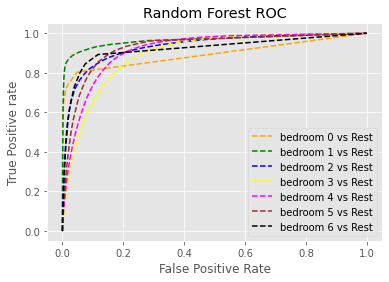

Confusion Matrix RF
[[  169   244    73    29     9     4     0     0     0     0]
 [  124  9126  1565   395    97    19     2     2     0     0]
 [   14   806 43506 11700   390    35     8     1     1     0]
 [    4   129  6675 75409  7073   249    31     2     0     1]
 [    0    36   284  9609 20514  1653   103     6     2     0]
 [    0     8    47   799  3996  2531   237    25     2     0]
 [    0     2    12   121   547   758   258    36     2     3]
 [    0     0     4    18    67   128   116    20     6     1]
 [    0     1     0     9    18    33    39    19     3     0]
 [    0     0     2     5     3     8    11     4     1     1]]
              precision    recall  f1-score   support

           0      0.543     0.320     0.403       528
           1      0.882     0.805     0.842     11330
           2      0.834     0.771     0.801     56461
           3      0.769     0.842     0.804     89573
           4      0.627     0.637     0.632     32207
           5      0.467 

In [17]:
y_pred_rf=feat_imp.predict(X_test)
y_prob_pred_rf=feat_imp.predict_proba(X_test)
auc_rf = roc_auc_score(y_test, y_prob_pred_rf, multi_class='ovo', average='weighted')
plot_roc(y_prob_pred_rf,'Random Forest ROC')

print('Confusion Matrix RF')
print(metrics.confusion_matrix(y_test,y_pred_rf))
print(metrics.classification_report(y_test,y_pred_rf,digits=3))
print("Auc:",auc_rf)


Based on the Random Forest estimation the top five variables in terms of importance to predict the target variable are:
- 'total_floor_area'
- 'number_habitable_rooms'
- 'number_heated_rooms'
- 'latitude'
- 'longitude'

I have selected the first two variables 'total_floor_area', 'number_habitable_rooms' to find
what would be the impact on models performance if we just use two most important
features?

In [18]:
''' Split data on train and test'''

#Get all the independent variables
df_XS=df.copy()

# define response variable
df_y=df_XS['bedrooms']

# select two features based on feature importance from random forrest
df_XX=df_XS[['total_floor_area','number_habitable_rooms']]

# set global random state
random_state = 11

# split data
X_train, X_test, y_train, y_test = train_test_split(df_XX, df_y, test_size=0.2, random_state=random_state)


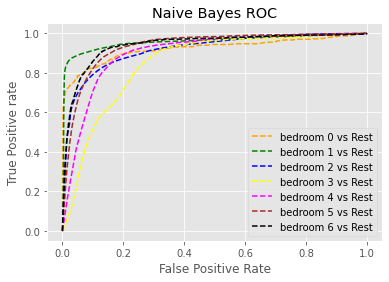

Confusion Matrix Naive Bayes
[[    0   404    87    23    11     3     0     0     0     0]
 [    0  8016  2831   356    93    24     4     3     0     3]
 [    0   427 46958  8677   334    46     2     3     0    14]
 [    0   125 16276 68193  4687   231    39    14     1     7]
 [    0    37   411 14257 15846  1516   111    19     1     9]
 [    0     6    55   833  4100  2315   279    47     5     5]
 [    0     3    22    92   551   769   211    69    10    12]
 [    0     0     2    17    61   124    88    50    10     8]
 [    0     0     0     3    20    39    28    16    12     4]
 [    0     0     1     5     2     5     7     9     3     3]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       528
           1      0.889     0.708     0.788     11330
           2      0.705     0.832     0.763     56461
           3      0.738     0.761     0.749     89573
           4      0.616     0.492     0.547     32207
           5   

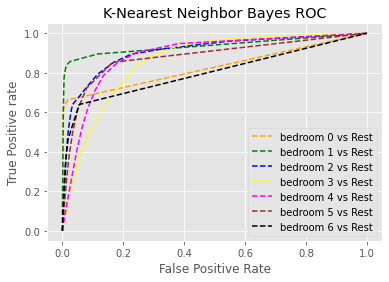

Confusion Matrix K-NN
[[  142   272    68    30    14     2     0     0     0     0]
 [  164  9056  1550   420   114    21     4     1     0     0]
 [   11   991 39400 15572   439    40     6     1     1     0]
 [    5   155  6531 75441  7185   238    17     1     0     0]
 [    0    38   276 11287 18902  1628    74     2     0     0]
 [    1     7    34   809  4344  2187   241    19     3     0]
 [    0     3    16   111   656   770   160    22     1     0]
 [    0     0     2    20    83   163    74    16     2     0]
 [    0     0     0     4    30    51    30     6     1     0]
 [    0     0     1     5     2    13     9     5     0     0]]
              precision    recall  f1-score   support

           0      0.440     0.269     0.334       528
           1      0.861     0.799     0.829     11330
           2      0.823     0.698     0.755     56461
           3      0.727     0.842     0.781     89573
           4      0.595     0.587     0.591     32207
           5      0.42

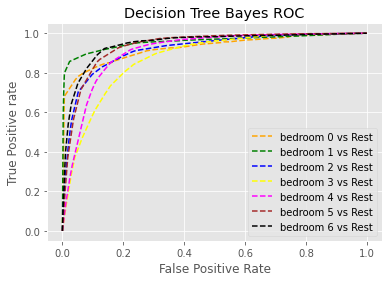

Confusion Matrix K-NN
[[    0   412    69    32    10     5     0     0     0     0]
 [    0  9087  1694   405   115    26     3     0     0     0]
 [    0   749 39709 15464   493    42     4     0     0     0]
 [    0   179  5404 75500  8188   280    22     0     0     0]
 [    0    52   254  9305 20610  1935    51     0     0     0]
 [    0    14    35   601  3968  2847   180     0     0     0]
 [    0     5    11    79   526   913   205     0     0     0]
 [    0     0     1    14    59   152   134     0     0     0]
 [    0     0     0     4    16    50    52     0     0     0]
 [    0     0     1     5     2     7    20     0     0     0]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       528
           1      0.866     0.802     0.833     11330
           2      0.842     0.703     0.766     56461
           3      0.745     0.843     0.791     89573
           4      0.606     0.640     0.623     32207
           5      0.45

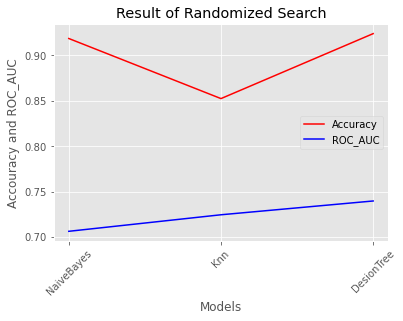

        Model  Accuracy_rate  Roc_auc_rate
0  NaiveBayes       0.706225      0.918685
1         Knn       0.724443      0.852471
2  DesionTree       0.739644      0.924053
Wall time: 15min 42s


In [19]:
%%time
model(X_train,y_train,X_test,y_test)

From the above analysis we can see that by choosing only two of the most important
variables the accuracy of the Naive Bayes and KNN has increased to 0.707666 and 0.724443
respectively. 